In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


In [22]:
!jupyter nbextension enable --py --sys-prefix widgetsnbextension
!jupyter labextension install @jupyter-widgets/jupyterlab-manager

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Building jupyterlab assets (build:prod:minimize)


In [19]:
! apt-get update && apt-get install -y nodejs

Hit:1 http://security.debian.org/debian-security buster/updates InRelease
Hit:2 http://deb.debian.org/debian buster InRelease
Hit:3 http://deb.debian.org/debian buster-updates InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libatomic1 libbrotli1 libc-ares2 libicu63 libnode64 libuv1 nodejs-doc
Suggested packages:
  npm
The following NEW packages will be installed:
  libatomic1 libbrotli1 libc-ares2 libicu63 libnode64 libuv1 nodejs nodejs-doc
0 upgraded, 8 newly installed, 0 to remove and 0 not upgraded.
Need to get 15.5 MB of archives.
After this operation, 64.3 MB of additional disk space will be used.
Get:1 http://security.debian.org/debian-security buster/updates/main amd64 libnode64 amd64 10.21.0~dfsg-1~deb10u1 [5629 kB]
Get:2 http://deb.debian.org/debian buster/main amd64 libatomic1 amd64 8.3.0-6 [9032 B]
Get:3 http://deb.debian.org/debian b

In [21]:
!apt-get install -y npm

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential bzip2 cpp
  cpp-8 dirmngr dpkg-dev fakeroot file g++ g++-8 gcc gcc-8 gnupg gnupg-l10n
  gnupg-utils gpg gpg-agent gpg-wks-client gpg-wks-server gpgconf gpgsm gyp
  javascript-common libalgorithm-diff-perl libalgorithm-diff-xs-perl
  libalgorithm-merge-perl libasan5 libassuan0 libbinutils libc-dev-bin
  libc6-dev libcc1-0 libdpkg-perl libfakeroot libfile-fcntllock-perl
  libgcc-8-dev libgdbm-compat4 libgomp1 libisl19 libitm1 libjs-inherits
  libjs-is-typedarray libksba8 libldap-2.4-2 libldap-common
  liblocale-gettext-perl liblsan0 libmagic-mgc libmagic1 libmpc3 libmpfr6
  libmpx2 libnode-dev libnpth0 libperl5.28 libpython-stdlib libpython2-stdlib
  libpython2.7-minimal libpython2.7-stdlib libquadmath0 libsasl2-2
  libsasl2-modules libsasl2-modules-db libssl-dev libstdc++-

# Sistema de duas massas suportadas verticalmente e em série por amortecedores e molas.


$ M\ddot{x} + C\dot{x} + Kx = F $

In [2]:

def k_matrix(k):
    return np.array([[k[0] - k[1], k[1]],
                    [-k[1], k[1]]])

def c_matrix(c):
    return np.array([[c[0] -c[1], c[1]],
                    [-c[1], c[1]]])
  
def m_matrix(m):
    return np.array([[m[0], 0],
                    [0, m[1]]])
  
def system_fun(m, k, c, g):

    K = k_matrix(k)
    C = c_matrix(c)
    M = m_matrix(m)

    print(K)
    print(C)
    print(M)
    def dxdt(t, x, F):
        x, x_dot = x.reshape((2, -1))
        x = x.reshape((-1, 1))
        x_dot = x_dot.reshape((-1, 1))


        x_dot2 = np.linalg.inv(M) @ ( F(t).reshape((-1,1)) - K @ x - C @ x_dot) + g*np.array([[1], [1]])
        return np.array([x_dot.reshape((-1,)), x_dot2.reshape((-1,))]).reshape((-1,))

    return dxdt


def get_position_and_force(m=1,k=2,c=1,g=9.81, dt=0.01, f=np.sin, steps=10000):

    dxdt = system_fun(m,k,c,g)

    y_buffer = []
    f_buffer = [[0,0]]
    y0 = np.array([0, 1, 0, 0])

    y_buffer.append(y0)


    for i in tqdm(range(steps)):
        sol = solve_ivp(dxdt, t_span=(dt*i,dt*(i+1)), y0=y0, args=(f,), t_eval=[dt*(i+1)])
        y0 = np.squeeze(sol["y"])
        y_buffer.append(y0)
        f_buffer.append(f(dt*(i+1)) + np.random.normal()*0)
  
    return np.array(y_buffer), np.array(f_buffer)

def f(t):
    return np.array([1, 1])*5*np.sin(2*np.pi*0.01*(t//1)**2*t)*np.sin(2*np.pi*0.004*(t//1)**2*t)
  #return np.array([0, 10*np.sin(2*np.pi*0.1*(t//1)**2*t)])

dt = 0.0001
m=[30, 60]
k=[5, 22]
c=[100, 52]

In [3]:
f(7)

array([1.53346333, 1.53346333])

[[-17  22]
 [-22  22]]
[[ 48  52]
 [-52  52]]
[[30  0]
 [ 0 60]]


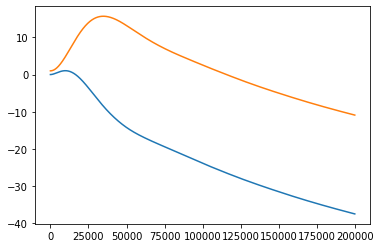

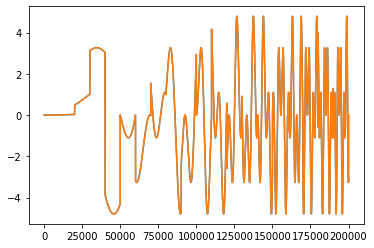

In [4]:
_positions, forces = get_position_and_force(m=m, k=k, c=c,f=f, dt=dt, steps=int(2e5))
positions = _positions[:, :2]
plt.plot(positions)
plt.show()
plt.plot(forces)
plt.show()

In [5]:
def second_order_diff(x, dt):

    diff = []
    for dim in x:
        diff.append(np.convolve(dim, np.array([1, - 2, 1]), mode="same")[1:-1]/(dt**2))
    return np.array(diff)

def first_order_diff(x, dt):

    diff = []
    for dim in x:
        diff.append(np.convolve(dim,  np.array([1, -1]), mode="same")[1:-1]/dt)
    return np.array(diff)


def build_dataset(x, f, dt):
    x_dot = first_order_diff(x.transpose(), dt).transpose()
    x_dot2 = second_order_diff(x.transpose(), dt).transpose()
    return x[1:-1], x_dot, x_dot2, f[1:-1]

x, x_dot, x_dot2, f = build_dataset(positions, forces, dt)

In [6]:
cc = np.concatenate([x, x_dot], axis=-1)

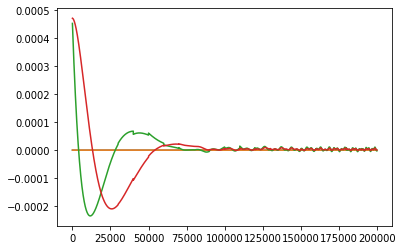

In [7]:
plt.plot(_positions[1:-1] - cc)

In [8]:
_positions[1:-1][20000:,2:]

array([[-4.14865924,  5.69304541],
       [-4.14892157,  5.69270274],
       [-4.14918385,  5.69236003],
       ...,
       [-1.04916644, -1.04622971],
       [-1.04917251, -1.04622966],
       [-1.04917858, -1.04622962]])

In [9]:
x_dot[20000:]

array([[-4.14852807,  5.69321674],
       [-4.14879041,  5.69287408],
       [-4.14905271,  5.69253139],
       ...,
       [-1.04916341, -1.04622973],
       [-1.04916948, -1.04622968],
       [-1.04917555, -1.04622964]])

# Jax

In [10]:
import jax
import jax.numpy as np
import numpy as onp
from jax import grad, jit, vmap, value_and_grad, jacfwd, jacrev, jacobian, hessian
from jax import random
from jax.experimental import stax
from jax.experimental.optimizers import adam, sgd


# Generate key which is used to generate random numbers
key = random.PRNGKey(1)

/usr/local/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


A equação do sistema é a seguinte:

$m\ddot{x} + c\dot{x} + kx = f - mg$

Queremos encontrar os parâmetros m, c e k.

## Modelo físico sem Lagrange

In [11]:
def initialize_params(key, dims):
    """ Inicializa massa m, k e c """
    keys = random.split(key, 3)
    params = [random.normal(keys[i], [dims, dims]) for i in range(3)]
    params[2] = np.tril(params[2])
    return params
    
def forward_pass(params, x, x_dot, x_dot2, f):
  """ 
  Uma instancia de x é do formato [x, x_dot] 
  Um forward pass estima a aceleração do sistema

  """
  x = x.reshape((-1, 1))
  x_dot = x_dot.reshape((-1, 1))
  x_dot2 = x_dot2.reshape((-1, 1))
  f = f.reshape((-1, 1))
  params[2] = np.tril(params[2]) 
  M_inv = np.linalg.pinv(params[2] @ params[2].transpose())
  C = params[1] @ x_dot 
  K = params[0] @ x
  return np.squeeze(M_inv @ (f - C - K) + 9.81, -1)


def mse(y_true, y_pred):
  diff = y_true - y_pred
  return np.mean(np.square(diff))

@jit
def loss(params, x, x_dot, x_dot2, f):
    pred = batch_forward_pass(params, x, x_dot, x_dot2, f)
    return mse(x_dot2, pred)

batch_forward_pass = vmap(forward_pass, in_axes=(None, 0, 0, 0, 0), out_axes=0)
params = initialize_params(key, 2)


In [12]:
forward_pass(params, x[0], x_dot[0], x_dot2[0], f[0])

DeviceArray([14.067913 , -1.7778721], dtype=float32)

In [13]:
batch_forward_pass(params, x[:10], x_dot[:10], x_dot2[:10], f[:10])

DeviceArray([[14.067913 , -1.7778711],
             [14.0729885, -1.7921925],
             [14.078062 , -1.8065081],
             [14.083135 , -1.8208227],
             [14.088207 , -1.8351345],
             [14.093277 , -1.8494425],
             [14.098347 , -1.8637476],
             [14.1034155, -1.8780508],
             [14.108484 , -1.8923502],
             [14.11355  , -1.9066477]], dtype=float32)

In [ ]:
batch_forward_pass(params, x[:10], x_dot[:10], x_dot2[:10], f[:10])

DeviceArray([[14.067917 , -1.7778788],
             [14.072992 , -1.7922001],
             [14.078068 , -1.8065233],
             [14.083143 , -1.8208427],
             [14.088219 , -1.835165 ],
             [14.093294 , -1.8494844],
             [14.098369 , -1.8638048],
             [14.103443 , -1.8781233],
             [14.108517 , -1.8924417],
             [14.113592 , -1.9067621]], dtype=float32)

In [14]:
loss(params, x[:10], x_dot[:10], x_dot2[:10], f[:10])

DeviceArray(76.33733, dtype=float32)

In [15]:
true_params = [np.array(k_matrix(k), dtype=np.float32), np.array(c_matrix(c), dtype=np.float32), np.array(m_matrix(m), dtype=np.float32)]

In [16]:
indexes = [i for i in range(len(x))]
onp.random.shuffle(indexes)
indexes

x = x[indexes]
x_dot = x_dot[indexes]
x_dot2 = x_dot2[indexes]
f = f[indexes]

In [17]:
undo_shuffle = onp.argsort(indexes)

Logo, se o modelo encontrar os bons parametros, teremos um MSE baixo

### Treinando

In [ ]:
step_size = 1
batch_size = 1
epochs = 100
init_fun, opt_update, get_params = adam(step_size=step_size)
params = initialize_params(key, 2)
true_params = [np.array(k_matrix(k), dtype=np.float32), np.array(c_matrix(c), dtype=np.float32), np.array(m_matrix(m), dtype=np.float32)]
true_params[2] = onp.linalg.cholesky(true_params[2])
#params=np.sqrt(true_params)
#params = true_params.copy()
#params = [ i + 0.5 for i in params]
opt_state = init_fun(params)


def train_step(x, x_dot, x_dot2, f, opt_state, opt_update):
  params = get_params(opt_state)
  mse, grad = value_and_grad(loss)(params, x, x_dot, x_dot2, f)
  opt_state = opt_update(0, grad, opt_state)
  params = get_params(opt_state)
  
  return get_params(opt_state), opt_state, mse


epoch_errors = []

print("True params:", true_params)
for epoch in range(epochs):

  n_batchs = len(x)//batch_size
  errors = []
  
  estimated_params = params.copy()


  estimated_params[2] = np.tril(estimated_params[2]) @ np.tril(estimated_params[2]).transpose()

  for i in range(len(true_params)):
    print(f"Params {i}:", np.mean(np.abs(true_params[i] - np.tril(estimated_params[i]))))

  
  print("Epoch", epoch)
  for i in tqdm(range(n_batchs)):
    x_batch = x[i*batch_size:((i+1)*batch_size)]
    x_dot_batch = x_dot[i*batch_size:((i+1)*batch_size)]
    x_dot2_batch = x_dot2[i*batch_size:((i+1)*batch_size)]
    f_batch = f[i*batch_size:((i+1)*batch_size)]
    params, opt_state, error = train_step(x_batch, x_dot_batch, x_dot2_batch, f_batch, opt_state, opt_update)
    errors.append(error)
  
  mean_error = np.mean(np.array(errors))
  print("Epoch", epoch, ", mean error:",mean_error, ", params:", np.array(params))
  
  epoch_errors.append(mean_error)
  

True params: [DeviceArray([[-17.,  22.],
             [-22.,  22.]], dtype=float32), DeviceArray([[ 48.,  52.],
             [-52.,  52.]], dtype=float32), array([[5.477226, 0.      ],
       [0.      , 7.745967]], dtype=float32)]
Params 0: 20.651405
Params 1: 51.022114
Params 2: 2.4950104
Epoch 0



Epoch 0 , mean error: 1.6248229 , params: [[[-113.97032    150.05757  ]
  [-166.219      162.8358   ]]

 [[ 369.62592    351.00055  ]
  [-456.2691     380.23206  ]]

 [[ -14.7520895    0.       ]
  [   1.6403877  -22.118227 ]]]
Params 0: 101.00629
Params 1: 276.53177
Params 2: 180.12674
Epoch 1



Epoch 1 , mean error: 0.014054734 , params: [[[-182.95844    240.34126  ]
  [-277.55603    272.17834  ]]

 [[ 586.1415     562.58813  ]
  [-750.19885    637.6489   ]]

 [[ -18.652552     0.       ]
  [   1.8203529  -28.53491  ]]]
Params 0: 173.4232
Params 1: 468.4973
Params 2: 296.55087
Epoch 2



Epoch 2 , mean error: 0.0121231 , params: [[[ -242.17029     318.06314  ]
  [ -373.65402     366.5849   ]]

 [[  773.7189      745.51917  ]
  [-1005.42523     859.9796   ]]

 [[  -21.455631      0.       ]
  [    2.0517783   -33.095997 ]]]
Params 0: 235.85231
Params 1: 634.7809
Params 2: 397.67447
Epoch 3



Epoch 3 , mean error: 0.011147624 , params: [[[ -296.21832     389.3009   ]
  [ -461.51114     452.99142  ]]

 [[  945.8584      913.2321   ]
  [-1239.9436     1063.7258   ]]

 [[  -23.722303      0.       ]
  [    2.2845576   -36.74942  ]]]
Params 0: 292.93024
Params 1: 787.38196
Params 2: 489.86462
Epoch 4



Epoch 4 , mean error: 0.010499186 , params: [[[ -346.756       456.26096  ]
  [ -543.83856     534.34485  ]]

 [[ 1107.7493     1069.907    ]
  [-1459.563      1254.8555   ]]

 [[  -25.639181      0.       ]
  [    2.4509773   -39.841885 ]]]
Params 0: 346.48486
Params 1: 930.54193
Params 2: 575.09216
Epoch 5



Epoch 5 , mean error: 0.010031914 , params: [[[ -394.76447     519.6943   ]
  [ -622.327       611.6621   ]]

 [[ 1261.9152     1218.5436   ]
  [-1667.8394     1436.8213   ]]

 [[  -27.320396      0.       ]
  [    2.5471659   -42.57597  ]]]
Params 0: 397.43842
Params 1: 1066.6439
Params 2: 655.4929
Epoch 6



Epoch 6 , mean error: 0.009673936 , params: [[[ -440.81735    580.21173 ]
  [ -697.7788     685.58136 ]]

 [[ 1409.7483    1360.9701  ]
  [-1867.7104    1611.438   ]]

 [[  -28.84629      0.      ]
  [    2.626503   -45.059666]]]
Params 0: 446.29437
Params 1: 1197.2241
Params 2: 732.9805
Epoch 7



Epoch 7 , mean error: 0.009386494 , params: [[[ -485.23752     638.4438   ]
  [ -770.6671      756.83234  ]]

 [[ 1552.2897     1498.2975   ]
  [-2061.016      1779.9407   ]]

 [[  -30.254055      0.       ]
  [    2.7156935   -47.34369  ]]]
Params 0: 493.43427
Params 1: 1323.3115
Params 2: 808.26135
Epoch 8



Epoch 8 , mean error: 0.009148249 , params: [[[ -528.2423      694.826    ]
  [ -841.33167     825.9199   ]]

 [[ 1690.3091     1631.2705   ]
  [-2248.8218     1943.2039   ]]

 [[  -31.563154      0.       ]
  [    2.8186557   -49.45977  ]]]
Params 0: 539.1235
Params 1: 1445.5837
Params 2: 881.54724
Epoch 9



Epoch 9 , mean error: 0.00894682 , params: [[[ -570.0004      749.64374  ]
  [ -910.0563      893.1816   ]]

 [[ 1824.4548     1760.439    ]
  [-2431.9543     2101.9106   ]]

 [[  -32.787487      0.       ]
  [    2.9324727   -51.43399  ]]]
Params 0: 583.5596
Params 1: 1564.58
Params 2: 952.9999
Epoch 10



Epoch 10 , mean error: 0.008773242 , params: [[[ -610.65753     803.1013   ]
  [ -977.0599      958.84247  ]]

 [[ 1955.211      1886.2487   ]
  [-2610.949      2256.5852   ]]

 [[  -33.938255      0.       ]
  [    3.0523288   -53.28699  ]]]
Params 0: 626.88995
Params 1: 1680.6863
Params 2: 1022.7482
Epoch 11



Epoch 11 , mean error: 0.008621115 , params: [[[ -650.32916    855.3465  ]
  [-1042.5195    1023.05994 ]]

 [[ 2082.9836    2009.0596  ]
  [-2786.306     2407.6453  ]]

 [[  -35.024925     0.      ]
  [    3.174952   -55.035835]]]
Params 0: 669.2272
Params 1: 1794.2336
Params 2: 1090.937
Epoch 12



Epoch 12 , mean error: 0.008486002 , params: [[[ -689.14276     906.5316   ]
  [-1106.6091     1085.9952   ]]

 [[ 2208.1492     2129.2637   ]
  [-2958.357      2555.5205   ]]

 [[  -36.05613       0.       ]
  [    3.2974865   -56.69463  ]]]
Params 0: 710.68677
Params 1: 1905.5066
Params 2: 1157.7177
Epoch 13



Epoch 13 , mean error: 0.0083646765 , params: [[[ -727.16693     956.73334  ]
  [-1169.4482     1147.7452   ]]

 [[ 2330.9214     2247.0813   ]
  [-3127.4043     2700.4983   ]]

 [[  -37.0383        0.       ]
  [    3.4182827   -58.274532 ]]]
Params 0: 751.3401
Params 1: 2014.706
Params 2: 1223.2064
Epoch 14



Epoch 14 , mean error: 0.008254735 , params: [[[ -764.4667     1006.0271   ]
  [-1231.1632     1208.4128   ]]

 [[ 2451.5525     2362.7214   ]
  [-3293.8306     2842.8748   ]]

 [[  -37.977264      0.       ]
  [    3.5369997   -59.78562  ]]]
Params 0: 791.2607
Params 1: 2122.0645
Params 2: 1287.5515
Epoch 15



Epoch 15 , mean error: 0.008154291 , params: [[[ -801.1323     1054.5162   ]
  [-1291.8225     1268.057    ]]

 [[ 2570.273      2476.4624   ]
  [-3457.7124     2982.82     ]]

 [[  -38.878384      0.       ]
  [    3.6522727   -61.23484  ]]]
Params 0: 830.5029
Params 1: 2227.7014
Params 2: 1350.8362
Epoch 16



Epoch 16 , mean error: 0.008061906 , params: [[[ -837.1991     1102.2334   ]
  [-1351.5352     1326.7825   ]]

 [[ 2687.1187     2588.3992   ]
  [-3619.1836     3120.5986   ]]

 [[  -39.744995      0.       ]
  [    3.7628398   -62.62897  ]]]
Params 0: 869.1292
Params 1: 2331.725
Params 2: 1413.1356
Epoch 17



Epoch 17 , mean error: 0.007976479 , params: [[[ -872.7104    1149.2308  ]
  [-1410.3593    1384.6323  ]]

 [[ 2802.2854    2698.6697  ]
  [-3778.471     3256.3364  ]]

 [[  -40.580723     0.      ]
  [    3.869502   -63.973484]]]
Params 0: 907.1755
Params 1: 2434.2732
Params 2: 1474.5447
Epoch 18


In [63]:
params

[DeviceArray([[-31.111414,  41.297615],
              [-34.85972 ,  33.193047]], dtype=float32),
 DeviceArray([[ 106.690315,   97.19048 ],
              [-111.132416,   78.42623 ]], dtype=float32),
 DeviceArray([[ -7.8212013,   0.       ],
              [  1.2441558, -10.407504 ]], dtype=float32)]

In [64]:
estimated_params

[DeviceArray([[-30.467466,  40.55112 ],
              [-33.442963,  31.778858]], dtype=float32),
 DeviceArray([[ 105.20385,   95.8488 ],
              [-107.64059,   75.45428]], dtype=float32),
 DeviceArray([[ 60.112762,  -9.822801],
              [ -9.822801, 106.315765]], dtype=float32)]

In [65]:
for i in range(len(true_params)):
  print(true_params[i] - estimated_params[i])

[[ 13.467466 -18.55112 ]
 [ 11.442963  -9.778858]]
[[-57.20385  -43.8488  ]
 [ 55.640587 -23.454277]]
[[-54.635536   9.822801]
 [  9.822801 -98.5698  ]]


In [66]:
print(k)
print(c)
print(m)
for i in true_params:
  print(i)

[5, 22]
[100, 52]
[30, 60]
[[-17.  22.]
 [-22.  22.]]
[[ 48.  52.]
 [-52.  52.]]
[[5.477226 0.      ]
 [0.       7.745967]]


In [67]:
print([params[0][0,0] + params[0][0,1], params[0][0,1]])
print([params[1][0,0] + params[1][0,1], params[1][0,1]])
for i in params:
  print(i)

[DeviceArray(10.186201, dtype=float32), DeviceArray(41.297615, dtype=float32)]
[DeviceArray(203.8808, dtype=float32), DeviceArray(97.19048, dtype=float32)]
[[-31.111414  41.297615]
 [-34.85972   33.193047]]
[[ 106.690315   97.19048 ]
 [-111.132416   78.42623 ]]
[[ -7.8212013   0.       ]
 [  1.2441558 -10.407504 ]]


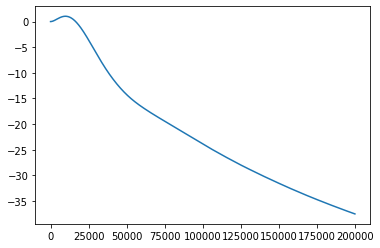

In [68]:
plt.plot(x[:,0][undo_shuffle])

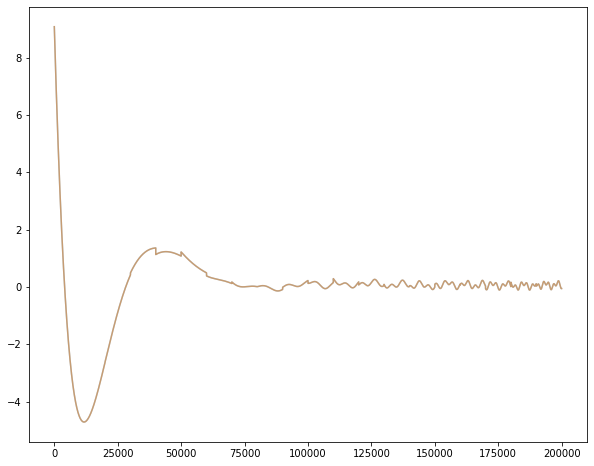

In [69]:

pred = batch_forward_pass(true_params, x, x_dot, x_dot2, f)[undo_shuffle]

plt.figure(figsize=(10,8))
plt.plot(x_dot2[:, 0][undo_shuffle], alpha=0.5)
plt.plot(pred[:, 0], alpha=0.5)


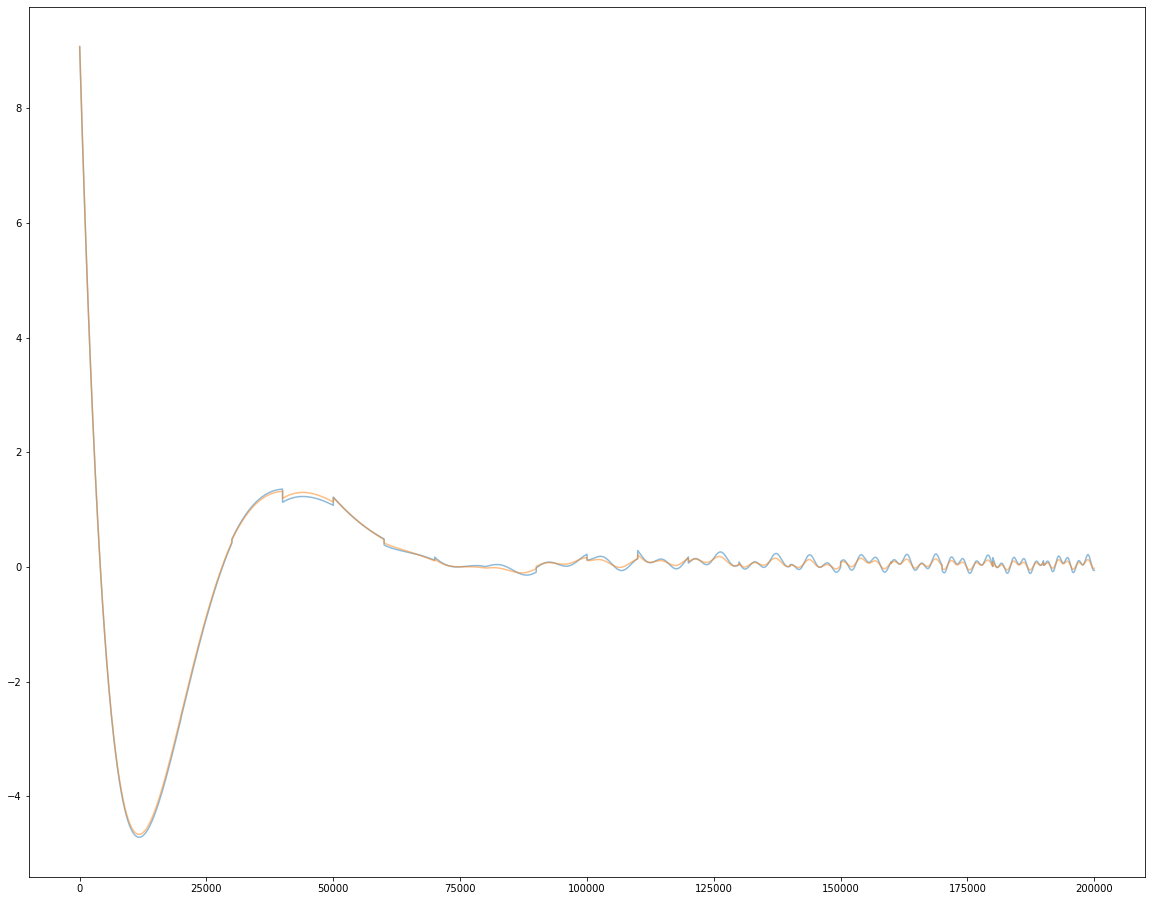

In [70]:
pred = batch_forward_pass(params, x, x_dot, x_dot2, f)[undo_shuffle]

plt.figure(figsize=(20,16))
plt.plot(x_dot2[undo_shuffle][:, 0], alpha=0.5)
plt.plot(pred[:, 0], alpha=0.5)


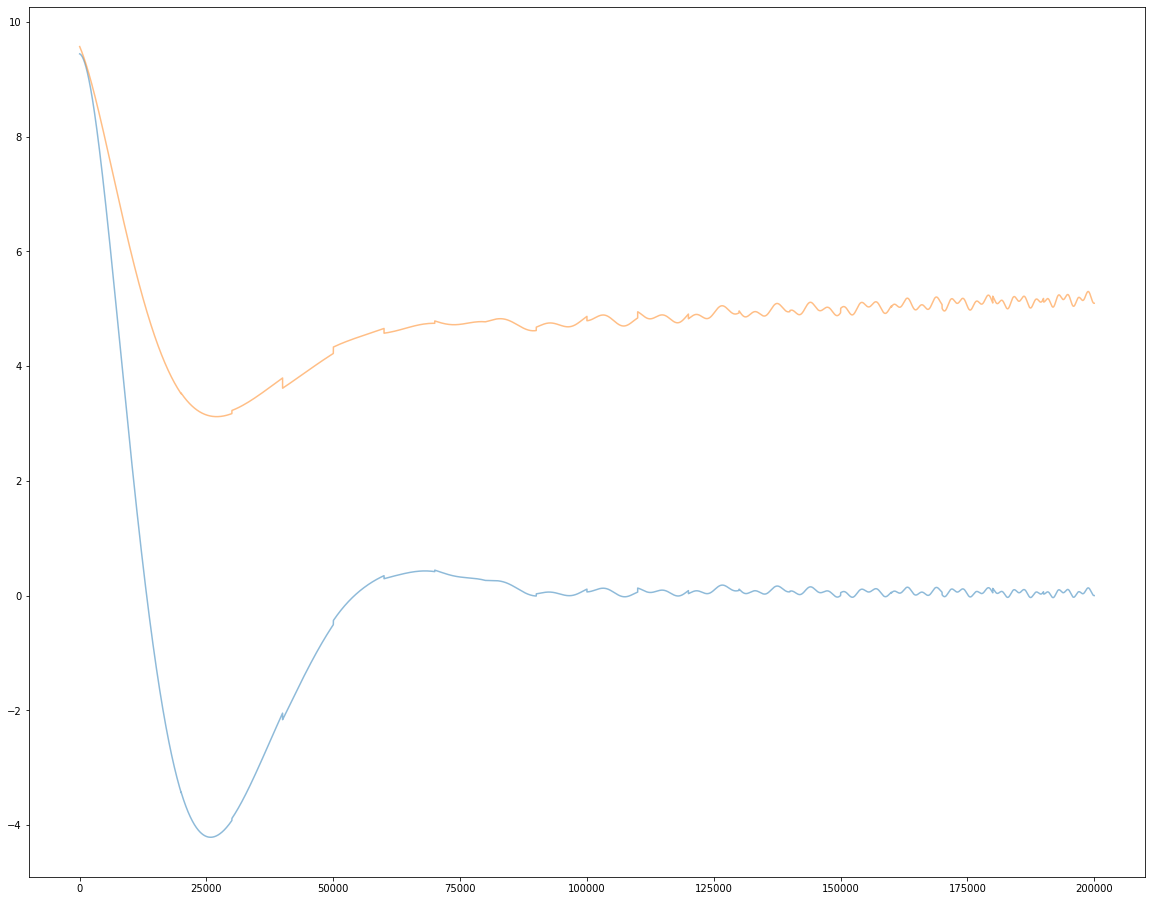

In [61]:
pred = batch_forward_pass(params, x, x_dot, x_dot2, f)[undo_shuffle]

plt.figure(figsize=(20,16))
plt.plot(x_dot2[undo_shuffle][:, 1], alpha=0.5)
plt.plot(pred[:, 1], alpha=0.5)


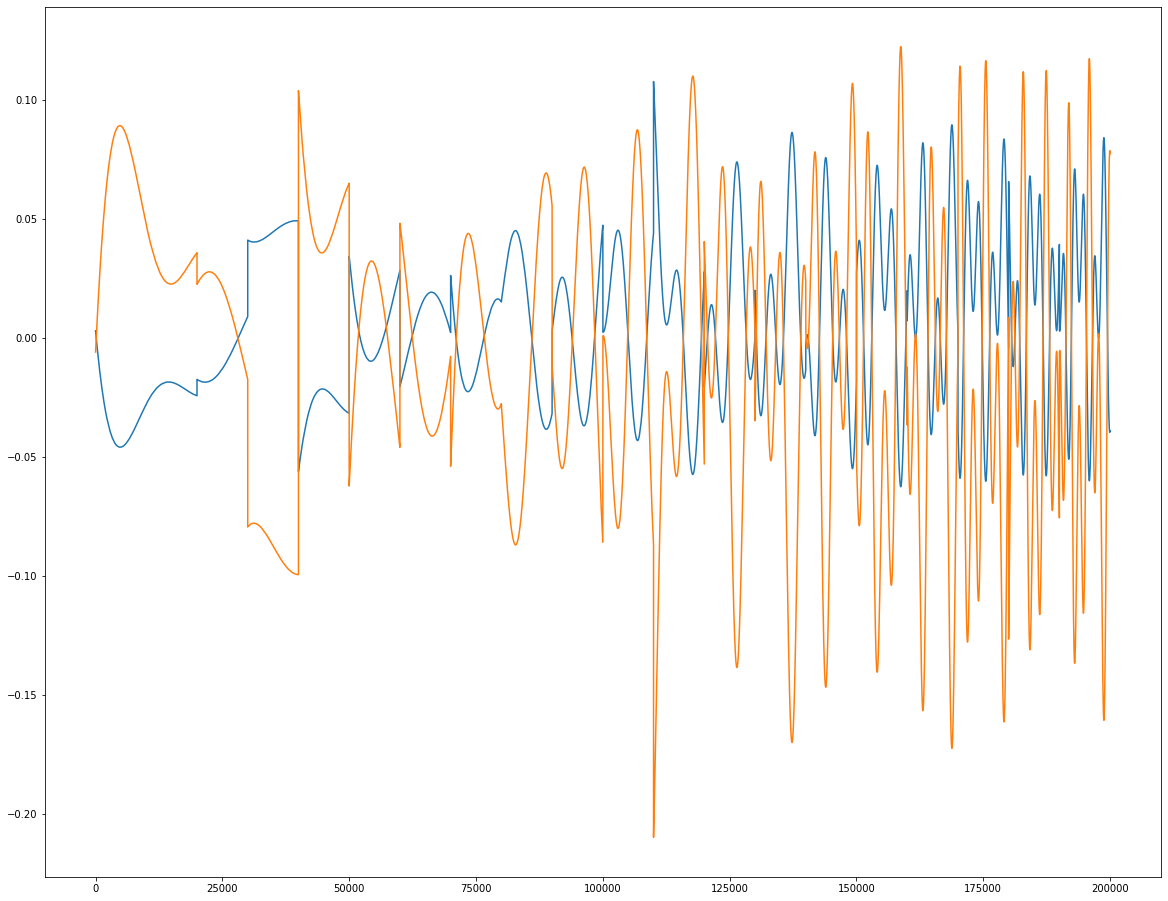

In [ ]:
plt.figure(figsize=(20,16))
plt.plot(batch_forward_pass(true_params, x, x_dot, x_dot2, f)[undo_shuffle] - batch_forward_pass(params, x, x_dot, x_dot2, f)[undo_shuffle])

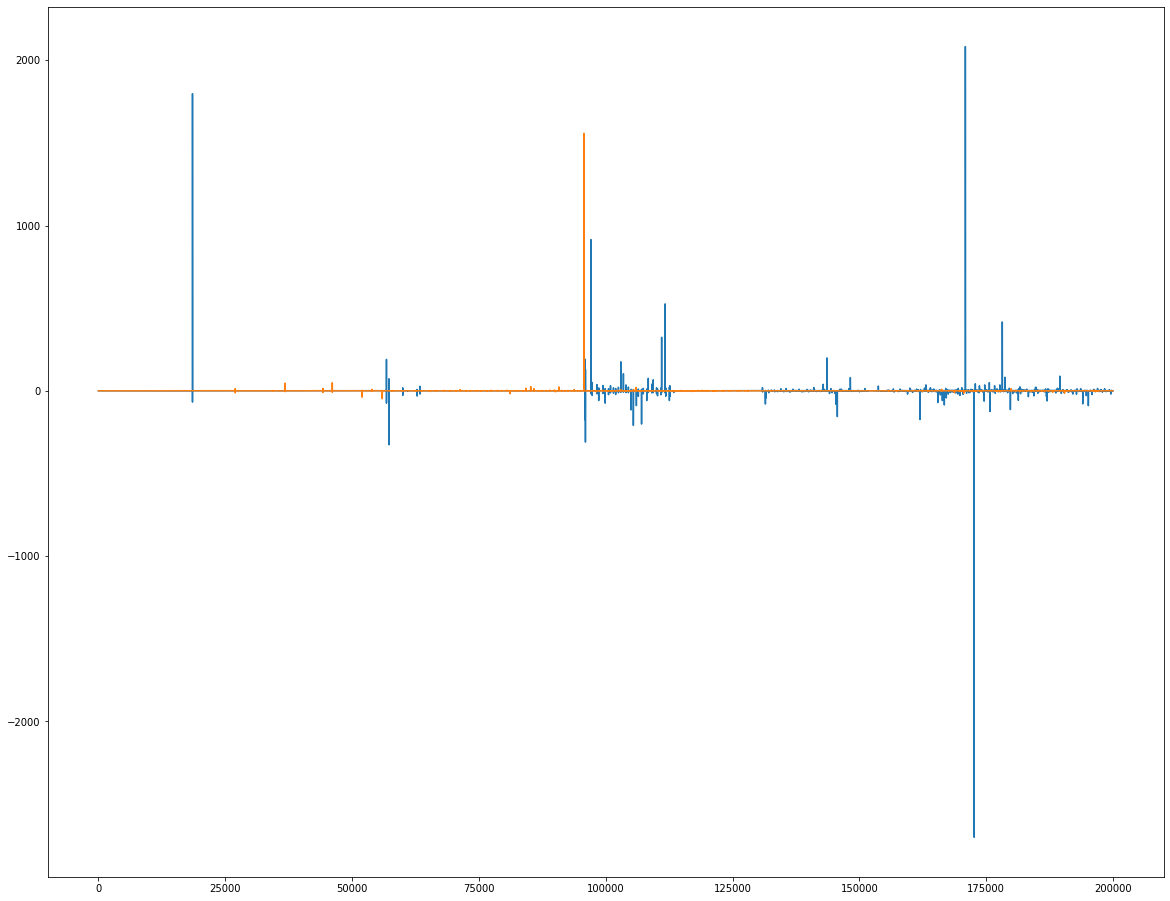

In [ ]:
plt.figure(figsize=(20,16))
plt.plot((batch_forward_pass(true_params, x, x_dot, x_dot2, f)[undo_shuffle] - batch_forward_pass(params, x, x_dot, x_dot2, f)[undo_shuffle])/batch_forward_pass(true_params, x, x_dot, x_dot2, f)[undo_shuffle])

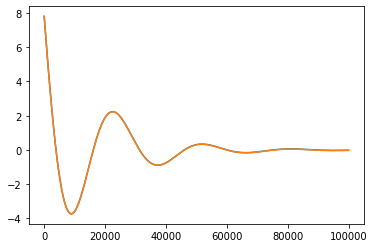

In [ ]:
pred = batch_forward_pass(true_params, x, x_dot, x_dot2, f)
plt.plot(x_dot2[:, 0])
plt.plot(pred[:, 0])


In [ ]:
[i**2 for i in params]

## Modelo com Lagrange

## Lagrange (baseado no paper)

In [ ]:
def neural_network_layer(key, dim_in, dim_out):
    w_key, b_key = random.split(key, 2)
    return random.normal(w_key, (dim_out, dim_in)), random.normal(b_key, (dim_out,))

def neural_network_params(key, layers):

    keys = random.split(key, len(layers))
    return [neural_network_layer(keys[i], layers[i], layers[i+1]) for i in range(len(layers)-1)]

def relu(x):
    return np.maximum(x, 0)

def forward_neural_network(layers, x, activation_fun=jax.nn.softplus):
    for w, b in layers[:-1]:
      x = np.dot(w, x) + b
      x = activation_fun(x)
    w, b = layers[-1]
    return np.dot(w, x) + b

def initialize_params(key, network_layers=[2, 300, 300, 1], damp_layers=[1, 300, 300, 1]):
    """ 
    Inicializa massa m, k e c 

    Returns
      params, list de tamanho 3, contendo arrays de tamanho <dims>
      params[0] -> k
      params[1] -> c
      params[2] @ params[2] -> m

    """
    params_l = neural_network_params(key, network_layers)
    params_c = neural_network_params(key, damp_layers)
    return [params_l, params_c]

def lagrangian(params, x, x_dot):
  x = np.concatenate([x, x_dot], axis=-1)
  return np.squeeze(forward_neural_network(params[0], x), axis=-1)

def forward_pass(params, x, x_dot, f):
  """ 
  Uma instancia de x é do formato [x, x_dot] 
  Um forward pass estima a aceleração do sistema
  
  """
  H = hessian(lagrangian, 2)(params, x, x_dot)
  H_inv = jax.numpy.linalg.pinv(H)

  #damping_force= forward_neural_network(params[1], x_dot)

  return H_inv @ (jacobian(lagrangian, 1)(params, x, x_dot) - jacobian(jacobian(lagrangian, 2), 1)(params, x, x_dot) @ x_dot)


def mse(y_true, y_pred):
  diff = y_true - y_pred
  return np.mean(np.square(diff))

@jit
def loss(params, x, x_dot, x_dot2, f):
    pred = batch_forward_pass(params, x, x_dot, f)
    return mse(x_dot2, pred)


batch_forward_pass = vmap(forward_pass, in_axes=(None, 0, 0, 0), out_axes=0)
params = initialize_params(key)

# To column vector
x = np.expand_dims(x_in[:, 0], 1)
x_dot = np.expand_dims(x_in[:, 1], 1)
x_dot2 = x_out
f =  np.expand_dims(x_in[:, 2], 1)


In [ ]:
hessian(lagrangian, 2)(params, np.array(x[0]), np.array(x_dot[0]))

DeviceArray([[63.834743]], dtype=float32)

In [ ]:
hessian(lagrangian, 2)(params, x[0], x_dot[0])

DeviceArray([[63.834743]], dtype=float32)

In [ ]:
forward_neural_network(params[0], np.concatenate([x[0], x_dot[0]], axis=-1))

DeviceArray([-92.79093], dtype=float32)

In [ ]:
hessian(forward_neural_network, 1)(params[1], x_dot[0])


DeviceArray([[[-189.57199]]], dtype=float32)

In [ ]:
forward_pass(params, x[100], x_dot[100], f[100])

DeviceArray([-2.1348817], dtype=float32)

In [ ]:
lagrangian(params, x[0], x_dot[0])

DeviceArray(-92.79093, dtype=float32)

In [ ]:
hessian(lagrangian, 1)(params, x[0], x_dot[1])

DeviceArray([[88.09747]], dtype=float32)

In [ ]:

step_size = 0.001
batch_size = 128
epochs = 50
init_fun, opt_update, get_params = adam(step_size=step_size)
params = initialize_params(key)
true_params = np.array([k, c, m])
#params=np.sqrt(true_params)
opt_state = init_fun(params)


def train_step(params, x, x_dot, x_dot2, f, opt_state, opt_update):
  params = get_params(opt_state)
  mse, grad = value_and_grad(loss)(params, x, x_dot, x_dot2, f)
  opt_state = opt_update(0, grad, opt_state)

  return get_params(opt_state), opt_state, mse


epoch_errors = []

for epoch in range(epochs):

  n_batchs = len(x_in)//batch_size
  errors = []
  
  print("Epoch", epoch)
  for i in tqdm(range(n_batchs)):
    x_batch = x[i*batch_size:((i+1)*batch_size)]
    x_dot_batch = x_dot[i*batch_size:((i+1)*batch_size)]
    x_dot2_batch = x_dot2[i*batch_size:((i+1)*batch_size)]
    f_batch = f[i*batch_size:((i+1)*batch_size)]
    params, opt_state, error = train_step(params, x_batch, x_dot_batch, x_dot2_batch, f_batch, opt_state, opt_update)
    errors.append(error)
  
  mean_error = np.mean(np.array(errors))
  print("Epoch", epoch, ", mean error:",mean_error)
  
  epoch_errors.append(mean_error)
  

Epoch 0



Epoch 0 , mean error: 155222.86
Epoch 1



Epoch 1 , mean error: 288112.4
Epoch 2



Epoch 2 , mean error: 345316.47
Epoch 3


KeyboardInterrupt: ignored

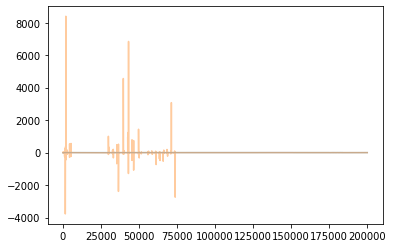

In [ ]:
pred = batch_forward_pass(params, x, x_dot, f)
plt.plot(x_dot2, alpha=0.4)
plt.plot(pred, alpha=0.4)

## Lagrange com imposição das variáveis

In [ ]:
def neural_network_layer(key, dim_in, dim_out):
    w_key, b_key = random.split(key, 2)
    return random.normal(w_key, (dim_out, dim_in)), random.normal(b_key, (dim_out,))

def neural_network_params(key, layers):

    keys = random.split(key, len(layers))
    return [neural_network_layer(keys[i], layers[i], layers[i+1]) for i in range(len(layers)-1)]

def relu(x):
    return np.maximum(x, 0)

def forward_neural_network(layers, x, activation_fun=relu):
    for w, b in layers[:-1]:
      x = np.dot(w, x) + b
      x = activation_fun(x)
    w, b = layers[-1]
    return np.dot(w, x) + b

def initialize_params(key, dims=1, potential_network_layers=[1, 100, 10, 1]):
    """ 
    Inicializa massa m, k e c 

    Returns
      params, list de tamanho 3, contendo arrays de tamanho <dims>
      params[0] -> k
      params[1] -> c
      params[2] @ params[2] -> m

    """
    assert(dims == potential_network_layers[0])

    keys = random.split(key, 4)
    params = [random.normal(keys[i], [dims, dims]) for i in range(3)]
    params[2] = np.tril(params[2])

    params.append(neural_network_params(keys[4], layers=potential_network_layers))
    return params

def lagrangian(params, x, x_dot):
  V = x.transpose() @ params[0] @ x / 2 + params[2] @ forward_neural_network(params[3], x)
  T = x_dot.transpose() @ (params[2] @ params[2]) @ x_dot / 2
  return (T - V)[0]




def forward_pass(params, x, x_dot, f):
  """ 
  Uma instancia de x é do formato [x, x_dot] 
  Um forward pass estima a aceleração do sistema
  
  """
  H = hessian(lagrangian, 2)(params, x, x_dot)
  H_inv = jax.numpy.linalg.pinv(H)

  return H_inv @ (jacobian(lagrangian, 1)(params, x, x_dot) - jacobian(jacobian(lagrangian, 2), 1)(params, x, x_dot) @ x_dot + f - params[1] @ x_dot)


def mse(y_true, y_pred):
  diff = y_true - y_pred
  return np.mean(np.square(diff))

@jit
def loss(params, x, x_dot, x_dot2, f):
    pred = batch_forward_pass(params, x, x_dot, f)
    return mse(x_dot2, pred)


batch_forward_pass = vmap(forward_pass, in_axes=(None, 0, 0, 0), out_axes=0)
params = initialize_params(key, dims=1)

# To column vector
x = np.expand_dims(x_in[:, 0], 1)
x_dot = np.expand_dims(x_in[:, 1], 1)
x_dot2 = x_out
f =  np.expand_dims(x_in[:, 2], 1)


In [ ]:
forward_neural_network(params[3], x[0])

DeviceArray([11.591677], dtype=float32)

In [ ]:
lagrangian(params, x[0], x_dot[0])

DeviceArray(9.512458, dtype=float32)

In [ ]:
batch_forward_pass(params, x[:10], x_dot[:10], f[:10])

DeviceArray([[-5.003113 ],
             [-4.982907 ],
             [-4.962744 ],
             [-4.942627 ],
             [-4.922553 ],
             [-4.9025235],
             [-4.8825374],
             [-4.862596 ],
             [-4.8426986],
             [-4.822845 ]], dtype=float32)

In [ ]:
val, grad = value_and_grad(loss)(params, x[:10], x_dot[:10], x_dot2[:10], f[:10])

In [ ]:
step_size = 0.1
batch_size = 128
epochs = 50
init_fun, opt_update, get_params = adam(step_size=step_size)
params = initialize_params(key)
true_params = np.array([k, c, m])
#params=np.sqrt(true_params)
opt_state = init_fun(params)


def train_step(params, x, x_dot, x_dot2, f, opt_state, opt_update):
  params = get_params(opt_state)
  mse, grad = value_and_grad(loss)(params, x, x_dot, x_dot2, f)
  opt_state = opt_update(0, grad, opt_state)

  return get_params(opt_state), opt_state, mse


epoch_errors = []

for epoch in range(epochs):

  n_batchs = len(x_in)//batch_size
  errors = []
  
  print("Param error:", np.mean(np.abs(true_params - np.square(np.squeeze(np.array(params[:3]))))) )
  print("Epoch", epoch)
  for i in tqdm(range(n_batchs)):
    x_batch = x[i*batch_size:((i+1)*batch_size)]
    x_dot_batch = x_dot[i*batch_size:((i+1)*batch_size)]
    x_dot2_batch = x_dot2[i*batch_size:((i+1)*batch_size)]
    f_batch = f[i*batch_size:((i+1)*batch_size)]
    params, opt_state, error = train_step(params, x_batch, x_dot_batch, x_dot2_batch, f_batch, opt_state, opt_update)
    errors.append(error)
  
  mean_error = np.mean(np.array(errors))
  print("Epoch", epoch, ", mean error:",mean_error, ", params:", np.squeeze(np.array(params[:3])), "")
  
  epoch_errors.append(mean_error)
  

Param error: 0.991143
Epoch 0



Epoch 0 , mean error: 2.610826 , params: [-0.02033757  2.292048   -1.7713695 ] 
Param error: 2.4636068
Epoch 1



Epoch 1 , mean error: 1.1574622 , params: [-0.02038167  1.7157559  -1.1465678 ] 
Param error: 1.086007
Epoch 2



Epoch 2 , mean error: 14.52302 , params: [-0.02031001  2.4722698  -2.2412136 ] 
Param error: 3.378248
Epoch 3



Epoch 3 , mean error: 1.685457 , params: [-0.02030975  2.8584802  -2.208791  ] 
Param error: 4.016418
Epoch 4



Epoch 4 , mean error: 1.5234721 , params: [ 0.00508547  2.7174697  -2.116994  ] 
Param error: 3.6220932
Epoch 5



Epoch 5 , mean error: 1.4215415 , params: [-0.02034033  2.4370873  -1.8648646 ] 
Param error: 2.8055668
Epoch 6



Epoch 6 , mean error: 1.1607076 , params: [-0.02024745  2.1432734  -1.0232913 ] 
Param error: 1.5467787
Epoch 7



Epoch 7 , mean error: 1.4724212 , params: [-0.02043908  0.69904757 -1.0132965 ] 
Param error: 0.51256156
Epoch 8



Epoch 8 , mean error: 1.776231 , params: [-0.02042021  0.15061109 -1.5069246 ] 
Param error: 1.0825738
Epoch 9


KeyboardInterrupt: ignored

In [ ]:
hessian(lagrangian, 2)(params, x[0], x_dot[0])

DeviceArray([[0.9994398]], dtype=float32)

In [ ]:
i = 20000
print(forward_pass(params, x[i], x_dot[i], f[i]), x_dot2[i])

In [ ]:
forward_neural_network(params[3], x[i])

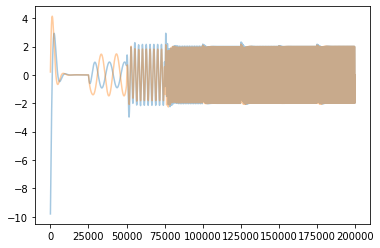

In [ ]:
pred = batch_forward_pass(params, x, x_dot, f)
plt.plot(x_dot2, alpha=0.4)
plt.plot(pred, alpha=0.4)

In [ ]:
n